In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import evaluate
import gensim
import transformers
import nltk
import torch_geometric
import json
from xml.dom import minidom
from tqdm import tqdm

from modeling import testModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

In [3]:
def read_svg_string(svg_strings):
    res = []

    panel_list = []

    for i in svg_strings:
        edge_list = []
        edge_index = []
        ps = 0
        pe = 0
        tmp = i.split()
        prev_x = float(tmp[1])
        prev_y = float(tmp[2])
        j = 3
        while j < len(tmp):
            edge = [prev_x, prev_y]
            if tmp[j] == 'z':
                break

            if tmp[j] == 'L':
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                prev_x = float(tmp[j+1])
                prev_y = float(tmp[j+2])
                edge.append((edge[0] + edge[2]) / 2)
                edge.append((edge[1] + edge[3]) / 2)
                j = j + 3
                pe += 1
                edge_list.append(edge)
                continue
            if tmp[j] == 'Q':
                prev_x = float(tmp[j+3])
                prev_y = float(tmp[j+4])
                edge.append(float(tmp[j+3]))
                edge.append(float(tmp[j+4]))
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                j = j + 5
                pe += 1
                edge_list.append(edge)
                continue
        for j in range(ps, pe - 1):
            edge_index.append([j, j + 1])
        edge_index.append([pe - 1, ps])
        edge_list = [convert_to_4(i) for i in edge_list]
        res.append([edge_list, edge_index])

    
    return res
            


In [4]:
def convert_to_4(data):
    start_p = np.array([data[0], data[1]])
    end_p = np.array([data[2], data[3]])
    center_p = np.array([data[4], data[5]])

    line = end_p - start_p
    p_line = np.empty_like(line)
    p_line[0] = - line[1]
    p_line[1] = line[0]

    v = center_p - start_p
    cx = np.dot(line, v) / np.linalg.norm(line)
    cy = np.dot(p_line, v) / np.linalg.norm(p_line)

    return [line[0], line[1], cx, cy]

In [5]:
def get_data_from_spec(file_path):
    doc = minidom.parse(file_path)  # parseString also exists
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    res = read_svg_string(path_strings)
    return res

In [6]:
def backto6(file_name, out, panel_list):
    doc = minidom.parse(file_name)  # parseString also exists
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    index = 0

    res = []
    
    for i, path in enumerate(path_strings):
        path = path.split()
        prev_x = float(path[1])
        prev_y = float(path[2])

        count = 1
        while count <= panel_list[i]:
            count += 1
            cur_x = prev_x + out[index][0]
            cur_y = prev_y + out[index][1]
            start_p = np.array([prev_x, prev_y])
            end_p = np.array([cur_x, cur_y])

            line = end_p - start_p
            
            p_line = np.empty_like(line)
            p_line[0] = - line[1]
            p_line[1] = line[0]

            center_p = start_p + line * out[index][2] / np.linalg.norm(line) + p_line * out[index][3] / np.linalg.norm(p_line)
            index += 1
            res.append([prev_x,prev_y, cur_x, cur_y, center_p[0], center_p[1]])
            prev_x = cur_x
            prev_y = cur_y
    return res

In [7]:
from os import listdir
from os.path import isfile, join
import random

mypath = "pants_straight_sides_1000"

onlyfiles_pants = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]
random.shuffle(onlyfiles_pants)

file_names_pants = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

mypath = "skirt_2_panels_1200"

onlyfiles_skirt = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]
random.shuffle(onlyfiles_skirt)

file_names_skirt = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

In [8]:
data_pants = [get_data_from_spec(i) for i in onlyfiles_pants]
data_skirt = [get_data_from_spec(i) for i in onlyfiles_skirt]

train_data_pants = data_pants[100:]
test_data_pants = data_pants[:100]

train_data_skirt = data_skirt[100:]
test_data_skirt = data_skirt[:100]

train_data = train_data_pants + train_data_skirt
test_data = test_data_pants + test_data_skirt

In [15]:
# -321 -- +408

In [16]:
lr = 1e-4
num_epochs = 50
n_classes= 147

model = testModel(4, 4 * n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25], gamma=0.1)

In [14]:
#training



train_loss_list = []
eval_loss_list = []

helper = [i for i in range(-321, 409)]
helper = torch.tensor(helper).to(device)

for epoch in tqdm(range(num_epochs), leave=False, position=0):
    
    epoch_loss = 0
    model.train()
    count = 0
    for data in tqdm(train_data, leave=False, position=1):
        for panel in data:
        

            label = []
            for i in panel[0]:
                for j in i:
                    #label.append(round(j + 321))
                    label.append(round((j + 321) / 5))
            label = torch.tensor(label).to(torch.long).to(device)
            
            input_data = torch.tensor(panel[0]).to(torch.float).to(device)
            edge_index = torch.tensor(panel[1]).to(device).permute(1,0)
                
            # Forward pass
            out = model(input_data, edge_index)
            #print(decoder_outputs.size())
                
            # print(out.shape)
            out = out.reshape(-1, n_classes)
            # Compute loss
            loss = criterion(out, label)
            """ # the loss of enclosing
            tmp = out.reshape(-1, 4, 730)
            tmp = tmp * helper
            tmp = tmp.sum(-1)
            tmp = tmp.sum(dim = 0)
            
            
            loss_0 = torch.square(tmp[0]) + torch.square(tmp[1])
            loss += loss_0 """

            
            epoch_loss += loss.item()
                
                
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            count += 1
        
    
        

    print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / count):.4f}')
    train_loss_list.append(epoch_loss / len(train_data))
    #eval
    eval_loss = 0
    model.eval()
    count = 0
    with torch.no_grad():
        for data in  test_data:
            for panel in data:
                label = []
                for i in panel[0]:
                    for j in i:
                        #label.append(round(j + 321))
                        label.append(round((j + 321) / 5))
                label = torch.tensor(label).to(torch.long).to(device)

                input_data = torch.tensor(panel[0]).to(torch.float).to(device)
                edge_index = torch.tensor(panel[1]).to(device).permute(1,0)
                    
                # Forward pass
                out = model(input_data, edge_index)
                #print(decoder_outputs.size())
                out = out.reshape(-1, n_classes)
                # Compute loss
                loss = criterion(out, label)
                """  # the loss of enclosing
                tmp = out.reshape(-1, 4, 730)
                tmp = tmp * helper
                tmp = tmp.sum(-1)
                tmp = tmp.sum(dim = 0)
                
                
                loss_0 = torch.square(tmp[0]) + torch.square(tmp[1])
                loss += loss_0 """
                
                eval_loss += loss.item()
                count += 1
    print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss / count):.4f}')
    eval_loss_list.append(eval_loss / len(test_data))
        
        

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 3.4445


  2%|▏         | 1/50 [01:28<1:12:12, 88.41s/it]

Epoch 1 | Eval Loss: 3.4666


Epoch 2 | Train Loss: 2.7024


  4%|▍         | 2/50 [02:55<1:09:52, 87.35s/it]

Epoch 2 | Eval Loss: 3.1849


Epoch 3 | Train Loss: 2.4113


  6%|▌         | 3/50 [04:21<1:08:12, 87.07s/it]

Epoch 3 | Eval Loss: 2.9836


Epoch 4 | Train Loss: 2.1498


  8%|▊         | 4/50 [05:49<1:06:51, 87.21s/it]

Epoch 4 | Eval Loss: 2.7175


Epoch 5 | Train Loss: 1.9075


 10%|█         | 5/50 [07:15<1:05:16, 87.03s/it]

Epoch 5 | Eval Loss: 2.4999


Epoch 6 | Train Loss: 1.7381


 12%|█▏        | 6/50 [08:42<1:03:42, 86.87s/it]

Epoch 6 | Eval Loss: 2.3782


Epoch 7 | Train Loss: 1.6218


 14%|█▍        | 7/50 [10:09<1:02:13, 86.82s/it]

Epoch 7 | Eval Loss: 2.2898


Epoch 8 | Train Loss: 1.5426


 16%|█▌        | 8/50 [11:35<1:00:43, 86.76s/it]

Epoch 8 | Eval Loss: 2.2239


Epoch 9 | Train Loss: 1.4877


 18%|█▊        | 9/50 [13:02<59:12, 86.65s/it]  

Epoch 9 | Eval Loss: 2.1641


Epoch 10 | Train Loss: 1.4470


 20%|██        | 10/50 [14:35<59:07, 88.69s/it]

Epoch 10 | Eval Loss: 2.0962


Epoch 11 | Train Loss: 1.4157


 22%|██▏       | 11/50 [16:10<58:59, 90.74s/it]

Epoch 11 | Eval Loss: 2.0462


Epoch 12 | Train Loss: 1.3870


 24%|██▍       | 12/50 [17:45<58:15, 91.98s/it]

Epoch 12 | Eval Loss: 1.9816


Epoch 13 | Train Loss: 1.3626


 26%|██▌       | 13/50 [19:20<57:11, 92.74s/it]

Epoch 13 | Eval Loss: 2.0005


Epoch 14 | Train Loss: 1.3368


 28%|██▊       | 14/50 [20:55<56:02, 93.40s/it]

Epoch 14 | Eval Loss: 1.9688


KeyboardInterrupt: 

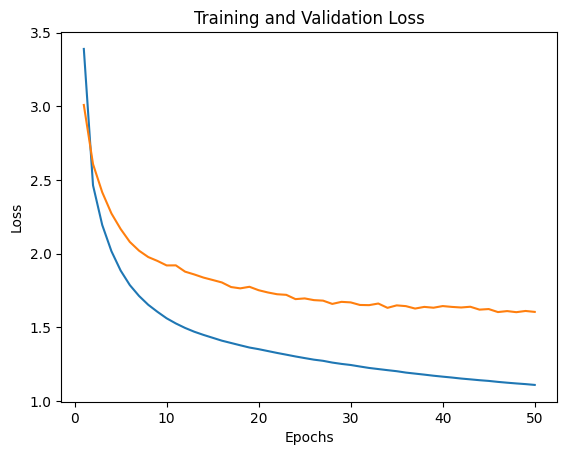

In [ ]:
from matplotlib.pylab import plt

epochs = range(1, 51)

plt.plot(epochs, train_loss_list, label='Training Loss')
plt.plot(epochs, eval_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [61]:
torch.save(model.state_dict(), 'models/classification(100_50)_3layers.pt')

In [20]:
def save_res(file_name, out):
    doc = minidom.parse(file_name)
    for i in out:
        tmp = []
        tmp.append('M')
        
        tmp.append(str(i[0]))
        tmp.append(str(i[1]))
        tmp.append("Q")
        tmp.append(str(i[4]))
        tmp.append(str(i[5]))
        tmp.append(str(i[2]))
        tmp.append(str(i[3]))
        x = doc.createElement("path")
        x.setAttribute("d" , " ".join(tmp))
        x.setAttribute("stroke" , "red")
        x.setAttribute("fill" , "none")
        doc.childNodes[0].appendChild(x)
    
    doc.writexml(open(join("res", file_name[-37:-4] + "_res.svg"), 'w'))
    

In [10]:
model = testModel(4, 4 * n_classes).to(device)
model.load_state_dict(torch.load('models/classification(100_50)_3layers.pt'))
model.eval()

testModel(
  (sage1): SAGEConv(4, 16, aggr=mean)
  (relu): ReLU()
  (sage2): SAGEConv(16, 32, aggr=mean)
  (sage3): SAGEConv(32, 64, aggr=mean)
  (resnet): ResNet1D(
    (first_block_conv): MyConv1dPadSame(
      (conv): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
    )
    (first_block_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (first_block_relu): ReLU()
    (basicblock_list): ModuleList(
      (0-3): 4 x BasicBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (do1): Dropout(p=0.5, inplace=False)
        (conv1): MyConv1dPadSame(
          (conv): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
        )
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
        (do2): Dropout(p=0.5, inplace=False)
        (conv2): MyConv1dPadSame(
          (conv): Conv1d(64, 64, kernel_size=(2,), stride=(1

In [22]:
names = onlyfiles_pants[:100] + onlyfiles_skirt[:100]
#names = onlyfiles_pants[-100:] + onlyfiles_skirt[-100:]

for name in names:
    a = get_data_from_spec(name)
    data = torch.tensor(a[0]).to(torch.float).to(device)
    edge_index = torch.tensor(a[1]).to(device).permute(1,0)
    
    
    out = model(data, edge_index)
    out = out.reshape(-1, n_classes)
    out = torch.argmax(out, dim=-1) * 5 - 320
    out =  out.reshape(-1,4)
    
    out = out.tolist()
    print(out)

    out = backto6(name, out, a[2])

    save_res(name,out)

[[105, 0, 60, 0], [-15, -150, 140, 15], [-75, 0, 40, 0], [-30, 75, 60, -25], [0, 105, 5, -10], [85, 0, 45, 0], [0, -120, 80, -10], [-30, -85, 25, -30], [-45, 0, 25, 0], [-15, 185, 20, 15], [105, 0, 50, 0], [0, -120, 80, -10], [-30, -90, 25, -30], [-75, 0, 25, 0], [-15, 155, 20, 15], [95, 0, 50, 0], [-15, -150, 140, 15], [-45, 0, 25, 0], [-30, 75, 60, -25], [0, 105, 5, -10]]
[[-120, 0, 60, 0], [15, -210, 205, 20], [-75, 0, 25, 0], [-30, 75, 60, -25], [0, 140, 10, -15], [-120, 0, 35, 0], [0, -175, 95, -15], [-30, -70, 25, -25], [-45, 0, 25, 0], [0, 170, 10, 15], [80, 0, 60, 0], [0, -175, 100, -15], [-30, -70, 20, -25], [-75, 0, 70, 0], [0, 155, 10, 15], [-120, 0, 60, 0], [15, -210, 205, 20], [-45, 0, 25, 0], [-30, 75, 60, -25], [0, 140, 10, -15]]
[[95, 0, 50, 0], [20, -130, 110, 10], [-75, 0, 40, 0], [-30, 70, 60, -25], [0, 90, 5, -5], [15, 0, 45, 0], [0, -95, 50, -10], [-30, -75, 25, -25], [-45, 0, 25, 0], [10, -130, 10, 10], [95, 0, 50, 0], [0, -95, 50, -5], [-30, -85, 25, -30], [-75, 

C:\Users\wangz\AppData\Local\Temp\ipykernel_15828\2474034235.py:28: RuntimeWarning: invalid value encountered in divide
  center_p = start_p + line * out[index][2] / np.linalg.norm(line) + p_line * out[index][3] / np.linalg.norm(p_line)


[[110, 0, 60, 0], [-15, -210, 195, 20], [-75, 0, 40, 0], [-30, 75, 60, 0], [0, 140, 10, -15], [85, 0, 45, 0], [0, -175, 150, -15], [-30, 0, 20, -25], [-45, 0, 25, 0], [0, 185, 10, 15], [105, 0, 60, 0], [0, -150, 150, -15], [-30, -70, 20, -25], [-75, 0, 60, 0], [0, 185, 10, 20], [80, 0, 45, 0], [-15, -215, 195, 20], [-45, 0, 25, 0], [-30, 75, 60, -25], [0, 155, 10, -15]]
[[105, 0, 60, 0], [15, -180, 170, 20], [-75, 0, 25, 0], [-30, 75, 60, -25], [0, 125, 10, -10], [65, 0, 35, 0], [0, -130, 130, -10], [-30, -70, 20, -25], [-45, 0, 25, 0], [0, 185, 10, 15], [95, 0, 50, 0], [0, -130, 125, -10], [-30, -70, 20, -25], [-75, 0, 25, 0], [10, 155, 10, 15], [75, 0, 35, 0], [15, -180, 170, 20], [-45, 0, 25, 0], [-30, 75, 60, -25], [0, 135, 10, -10]]
[[-120, 0, 60, 0], [15, -210, 205, 20], [-75, 0, 25, 0], [-30, 75, 60, -25], [0, 140, 10, -15], [-120, 0, 30, 0], [0, -160, 95, -15], [-30, -70, 25, -25], [-45, 0, 25, 0], [0, 105, 10, 15], [80, 0, 35, 0], [0, -150, 100, -15], [-30, -70, 20, -25], [-75